Based on [Hopfield Networks is All You Need](https://ml-jku.github.io/hopfield-layers/#hfnetworks) and [Week 08c: Hopfield Demonstration by Jeff Orchard](https://www.youtube.com/watch?v=81B-ESqgCjs)

In [1]:
import numpy as np, os, matplotlib.pyplot as plt
import copy
# set working dir to repo directory
head, tail = os.path.split(os.getcwd())
while tail != 'aj_python_tool_lib':
    head, tail = os.path.split(head)
os.chdir(os.path.join(head, tail))
os.getcwd()
from misc_tools.print_latex import print_tex

<IPython.core.display.Math object>

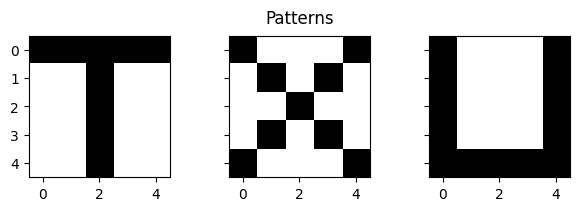

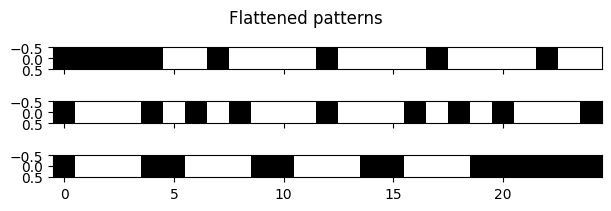

In [2]:
patterns = np.array([
    [
       [1,1,1,1,1],
       [0,0,1,0,0],
       [0,0,1,0,0],
       [0,0,1,0,0],
       [0,0,1,0,0]
        
    ],

    [
       [1,0,0,0,1],
       [0,1,0,1,0],
       [0,0,1,0,0],
       [0,1,0,1,0],
       [1,0,0,0,1]
        
    ],

    [
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,0,0,0,1],
       [1,1,1,1,1]
        
    ],

])

N_mem = len(patterns)

mem_shape_OG = patterns[0].shape

fig, ax = plt.subplots(1,N_mem, figsize = (2*N_mem,2), layout='constrained', sharex=True, sharey=True)
plt.suptitle('Patterns')

for a, pt in zip(ax, patterns):
   a.imshow(pt, 'gray_r')

remap = lambda x: 2*x - 1   # [0,1]-> [0,2] -> [-1,1]
patterns = remap(patterns)

# store it as columns. but its easier to retrieve via transpose.
patterns = patterns.reshape(N_mem, -1).T  # (-1,N_mem) fks internal ordering.

len_state = patterns.shape[0]

fig, ax = plt.subplots(N_mem,1, figsize = (2*N_mem,2), layout='constrained', sharex=True, sharey=True)
plt.suptitle('Flattened patterns')

for a, pt in zip(ax, patterns.T):
   a.imshow([pt], 'gray_r')

In [3]:
b = np.average(patterns, axis=1).reshape(-1,1)
#print_tex('bias = ', b, column=False)
b.shape

(25, 1)

### Weights:
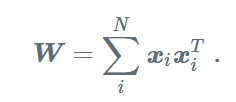

outer($\vec{x}_i, \vec{x}_i$) 
$=\vec{x}_i \bigotimes \vec{x}_i= \vec{x}_i \vec{x}^T_i= 
\begin{bmatrix} x_{1,i} \\ x_{2,i} \end{bmatrix} \begin{bmatrix} x_{1,i} & x_{2,i} \end{bmatrix} = 
\begin{bmatrix} x_{1,i} x_{1,i} & x_{1,i} x_{2,i} \\ x_{2,i} x_{1,i} & x_{2,i} x_{2,i}\end{bmatrix} $

$\sum_i^2 \vec{x}_i \bigotimes \vec{x}_i =
\begin{bmatrix} x_{1,1} x_{1,1} & x_{1,1} x_{2,1} \\ x_{2,1} x_{1,1} & x_{2,1} x_{2,1}\end{bmatrix}+
\begin{bmatrix} x_{1,2} x_{1,2} & x_{1,2} x_{2,2} \\ x_{2,2} x_{1,2} & x_{2,2} x_{2,2}\end{bmatrix} = 
\begin{bmatrix} x_{1,1} x_{1,1} + x_{1,2} x_{1,2}  &  \ldots \\ \ldots  & \ldots \end{bmatrix}=
$

$
\begin{bmatrix} \vec{x}_1^T \vec{x}_1  &  \ldots \\ \ldots  & \ldots \end{bmatrix}=
\begin{bmatrix} x_{1,1} & x_{2,1} \\ x_{1,2} & x_{2,2} \end{bmatrix}
\begin{bmatrix} x_{1,1} & x_{1,2} \\ x_{2,1} & x_{2,2} \end{bmatrix}=
X^TX = XX^T
$



(25, 3)


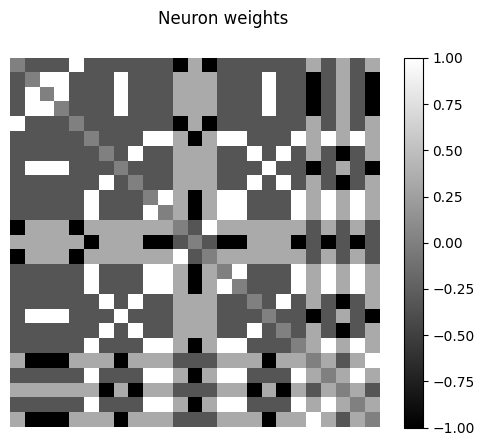

In [4]:
W = patterns @ patterns.T / N_mem - np.eye(len_state) 
print(patterns.shape)
#print_tex('W = ', W, column=False)
plt.imshow(W, 'gray')
plt.suptitle('Neuron weights')
plt.colorbar()
plt.axis('off');

### Hopfield energy:
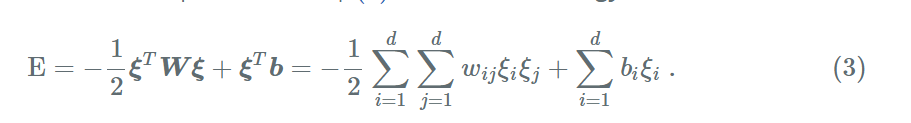

In [5]:
def state_energy(W, Xi, b):
    return -0.5 * Xi.T @ W @ Xi  + Xi.T @ b

def update_step(W,Xi,b):
        return np.sign(Xi @ W  - b).astype(int)

def Hamming_dist(x,y):
    return np.sum(x.flatten()!= y.flatten())

In [6]:
np.random.seed(69)
target_state = 0
state_og = patterns[:,target_state].reshape(-1,1)

perturb_prob = 0.3
mask_change = np.random.rand(*state_og.shape) < perturb_prob
mask_change = np.array(mask_change, int)    # once converted from bool cannot do a[mask], must do a[max==True] instead ?!
perturbed_state = copy.deepcopy(state_og)

perturbed_state[mask_change==True] *= -1

print_tex('og\_state \& mask \& new\_state =', np.hstack([state_og,mask_change,perturbed_state]).T, column=True)
print('Hamming_dist overlaps', Hamming_dist(state_og,perturbed_state)/len_state * 100, '% of total length')


<IPython.core.display.Math object>

Hamming_dist overlaps 36.0 % of total length


(25, 1)
Hamming dist for iter 0 =  12
Hamming dist for iter 1 =  5
Hamming dist for iter 2 =  2
Hamming dist for iter 3 =  0

Distances for all patrerns:
H-dist memory 0 -> new_state =  0
H-dist memory 1 -> new_state =  12
H-dist memory 2 -> new_state =  16


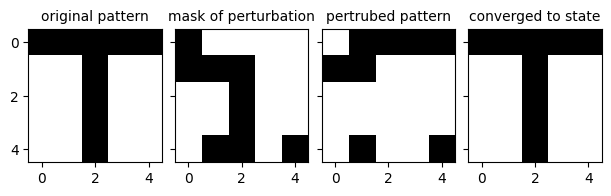

In [7]:
n_iters = 10
state = copy.deepcopy(perturbed_state)
print(state.shape)
for i in range(n_iters):
    #state_new = update_step(W,state,b)
    state_new = np.sign(W @ state - b)
    dist = Hamming_dist(state, state_new)
    print(f'Hamming dist for iter {i} = ',dist)
    state = state_new
    if dist == 0: break

print('\nDistances for all patrerns:')
for i,state in enumerate(patterns.T):
    print(f'H-dist memory {i} -> new_state = ', Hamming_dist(state, state_new))

fig, ax = plt.subplots(1,4, figsize = (2*N_mem,2), layout='constrained', sharex=True, sharey=True)
for a, st, lbl in zip(ax, [state_og,mask_change,perturbed_state,state_new],['original pattern', 'mask of perturbation', 'pertrubed pattern', 'converged to state']):
   a.imshow(st.reshape(*mem_shape_OG), 'gray_r')
   a.set_title(lbl, fontsize=10)
